In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cholesky, norm
from mosek.fusion import Matrix, Model, Domain, Expr, ObjectiveSense
from tqdm import tqdm

In [2]:
def load_test_graph():
    W = np.array([
        [0, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])
    return W


def generate_random_graph(n, seed=23):
    np.random.seed(seed)
    W = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            W[i,j] = W[j,i] = np.random.randint(2)
    return W


def solve_sdp_program(W):
    assert W.ndim == 2
    assert W.shape[0] == W.shape[1]
    W = W.copy()
    n = W.shape[0]
    with Model('gw_max_cut') as M:
        W = Matrix.dense(W / 4.)
        J = Matrix.ones(n, n)
        # variable
        Y = M.variable('Y', Domain.inPSDCone(n))
        # objective function
        M.objective(ObjectiveSense.Maximize, Expr.dot(W, Expr.sub(J, Y)))
        # constraints
        for i in range(n):
            M.constraint(f'c_{i}', Y.index(i, i), Domain.equalsTo(1.))
        # solve
        M.solve()
        # solution
        Y_opt = Y.level()
    RELAX = np.reshape(Y_opt, (n,n))
    return RELAX


def find_cut(A, W):
    assert A.ndim == W.ndim == 2
    assert A.shape[0] == A.shape[1] == W.shape[0] == W.shape[1]
    A = A.copy()
    W = W.copy()
    n = A.shape[0]
    # generate random vector on ndim-sphere
    r = np.random.normal(0, 1, n)
    r /= norm(r)
    # find cut
    S, S_comp = list(), list()
    for i in range(n): 
        if np.dot(A[i,:], r) >= 0:
            S.append(i)
        else:
            S_comp.append(i)
    # sum of cut weights
    sum_cut_weights = 0
    for i in S:
        for j in S_comp:
            sum_cut_weights += W[i][j]
    return {
        'S': S,
        'S_comp': S_comp,
        'sum_cut_weights': sum_cut_weights,
    }

In [3]:
W = generate_random_graph(100)
RELAX = solve_sdp_program(W)
A = cholesky(RELAX)
np.random.seed(1)
eps   = 0.00001
alpha = 0.87856
c = (eps * alpha) / (2 + 2 * eps - alpha)

In [4]:
print(int(1/c + 1))

127648


In [5]:
cut_sums = list()
best_sum = -1
best_S, best_S_comp = list(), list()
for _ in tqdm(range(int(1/c + 1))):
    res = find_cut(A, W)
    cut_sum = res.get('sum_cut_weights')
    cut_sums.append(cut_sum)
    if cut_sum > best_sum:
        best_sum = cut_sum
        best_S = res.get('S')
        best_S_comp = res.get('S_comp')

100%|██████████| 127648/127648 [03:17<00:00, 646.29it/s]


In [6]:
print(best_S)

[3, 4, 5, 7, 8, 15, 16, 20, 21, 22, 23, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 52, 55, 57, 58, 59, 62, 64, 66, 67, 78, 80, 83, 85, 89, 91, 95, 96, 99]


In [7]:
print(best_S_comp)

[0, 1, 2, 6, 9, 10, 11, 12, 13, 14, 17, 18, 19, 24, 25, 26, 29, 49, 51, 53, 54, 56, 60, 61, 63, 65, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 81, 82, 84, 86, 87, 88, 90, 92, 93, 94, 97, 98]


In [8]:
print(best_sum)

1422.0


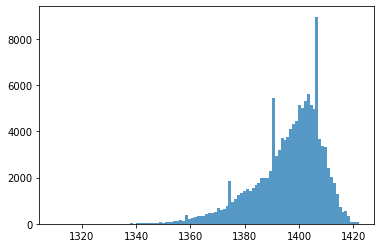

In [9]:
plt.hist(cut_sums, len(list(set(cut_sums))), alpha=0.75)
plt.show()